# Sqlite Tuning Experiment Analysis Notebook

Begin by running the following command in the integrated terminal in order to generate some trial data:

```sh
mlos_bench --config "./config/cli/local-sqlite-opt.jsonc" --globals "./config/experiments/sqlite-sync-journal-pagesize-caching-experiment.jsonc" --max-iterations 150
```

> See Also: [README.md](./README.md) for further instructions.

## Analyze the results

Next we can start analyzing the autotuning data produced by running the benchmark trials.

In [1]:
# Import a few popular third-party packages for data analysis. They come pre-installed with Anaconda.
import pandas
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Import mlos_bench Storage API to access the experimental data.
from mlos_bench.storage import from_config

In [3]:
# Cosmetic: Suppress some annoying warnings from third-party data visualization packages
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Connect using existing mlos_bench configs

In [4]:
storage = from_config(config_file="storage/sqlite.jsonc")

### Load a sqlite Experiment

In [5]:
storage.experiments

{'sqlite-sync-journal-pagesize-caching-experiment': Experiment :: sqlite-sync-journal-pagesize-caching-experiment: 'sqlite-local-benchbase'}

In [6]:
experiment_id = "sqlite-sync-journal-pagesize-caching-experiment"

## Get all data for one experiment

In [7]:
exp = storage.experiments[experiment_id]
display(exp)

Experiment :: sqlite-sync-journal-pagesize-caching-experiment: 'sqlite-local-benchbase'

In [8]:
# View some of the result data associated with that experiment.
df = exp.results
df.head()

,trial_id,ts_start,ts_end,config_id,status,config.cache_size,config.journal_mode,config.journal_size_limit,config.mmap_size,config.page_size,...,result.Socket messages received,result.Socket messages sent,result.Swaps,result.System time (seconds),result.Throughput (requests/second),result.User time (seconds),result.Voluntary context switches,result.isolation,result.scalefactor,result.terminals
0,0,2023-10-12 00:19:35.179108,2023-10-12 00:21:32.101952,1,SUCCEEDED,1,delete,-1,-1,4096,...,0,0,0,0.33,6.699841,2.81,14577,TRANSACTION_SERIALIZABLE,1,1
1,1,2023-10-12 00:21:32.201016,2023-10-12 00:21:46.432367,2,SUCCEEDED,1656398469,truncate,1633227268,363162755,2048,...,0,0,0,0.28,31.099798,3.37,14950,TRANSACTION_SERIALIZABLE,1,1
2,2,2023-10-12 00:21:46.494138,2023-10-12 00:22:00.870337,3,SUCCEEDED,1281136238,off,704594,779126884,2048,...,0,0,0,0.34,63.598733,3.76,15210,TRANSACTION_SERIALIZABLE,1,1
3,3,2023-10-12 00:22:00.936280,2023-10-12 00:22:15.337492,4,SUCCEEDED,948829517,wal,1120228729,1951308613,8192,...,0,0,0,0.32,63.094578,3.77,14829,TRANSACTION_SERIALIZABLE,1,1
4,4,2023-10-12 00:22:15.397273,2023-10-12 00:22:31.124095,5,SUCCEEDED,699030920,persist,2027784438,2120909557,8192,...,0,0,0,2.95,1440.387481,13.27,12883,TRANSACTION_SERIALIZABLE,1,1


In [9]:
# View some of the data associated with one of those trials.
# (includes metadata, config data, and results metrics data)
display(df.loc[1])

trial_id                                                                                              1
ts_start                                                                     2023-10-12 00:21:32.201016
ts_end                                                                       2023-10-12 00:21:46.432367
config_id                                                                                             2
status                                                                                        SUCCEEDED
config.cache_size                                                                            1656398469
config.journal_mode                                                                            truncate
config.journal_size_limit                                                                    1633227268
config.mmap_size                                                                              363162755
config.page_size                                                

### Plot the results

#### Plot the behavior of the optimizer

In [10]:
# TODO:
# 1. plot of the optimizer's best config found so far (convergence rate of the optimizer)
# 2. plot of the performance of each config the optimizer found (search behavior of the optimizer)

#### Plot the results of one metric vs. another for some tunable

The intent is to explore parameter importance and impact on different metrics (both application performance and system resource usage).

In [11]:
# Categorical tunable to consider:
CATEGORY = "config.synchronous"

# A system resource metric to analyze.
METRIC = "result.File system outputs"

# Which performance metric to plot on the Y-axis.
SCORE = "result.90th Percentile Latency (microseconds)"

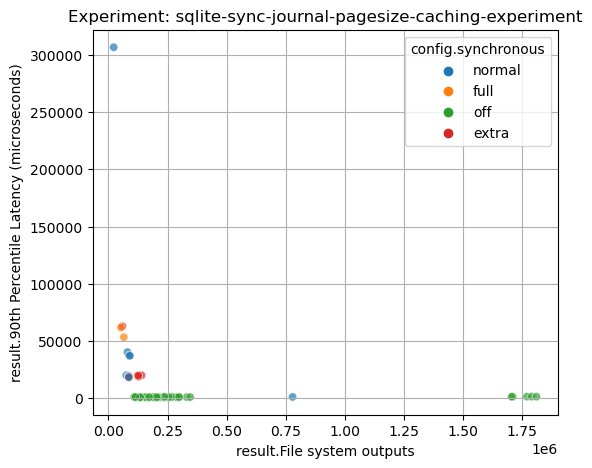

In [12]:
plt.rcParams["figure.figsize"] = (6, 5)

sns.scatterplot(data=df, x=METRIC, y=SCORE, hue=CATEGORY, marker='o', alpha=0.7)

plt.title("Experiment: " + exp.exp_id)
plt.grid()
plt.show()

We can see the results, but the outliers make it really difficult to see what's going on. Let's switch to the log scale and see if that helps.

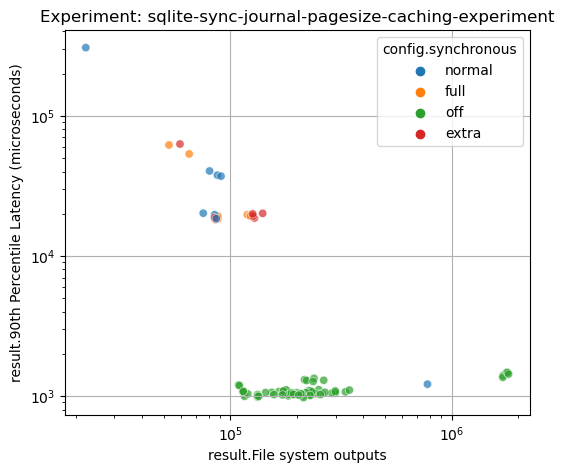

In [13]:
plt.rcParams["figure.figsize"] = (6, 5)

sns.scatterplot(data=df, x=METRIC, y=SCORE, hue=CATEGORY, marker='o', alpha=0.7)

plt.xscale('log')
plt.yscale('log')

plt.title("Experiment: " + exp.exp_id)
plt.grid()
plt.show()

 Now we can see that setting `synchronous=off` seems to seems to improve the latency a lot. Apparently, the optimizer had also noticed that and focused on exploring a particular area of the configuration space. Let's switch back to the linear scale and zoom in to that region.

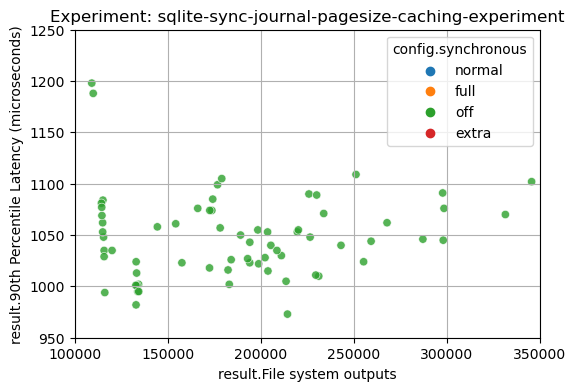

In [14]:
plt.rcParams["figure.figsize"] = (6, 4)

sns.scatterplot(data=df, x=METRIC, y=SCORE, hue=CATEGORY, marker='o', alpha=0.8)

plt.xlim(100000, 350000)
plt.ylim(950, 1250)

plt.title("Experiment: " + exp.exp_id)
plt.grid()
plt.show()

Now we can see that the latency is minimal when the configuration parameter `synchronous` is set to `off` and when the metric `File system outputs` is in range of 100..300K. Let's see what other configuration parameters get us there.

In [15]:
df_lim = df[(df[CATEGORY] == "off") & (df[METRIC] > 100000) & (df[METRIC] < 300000)]

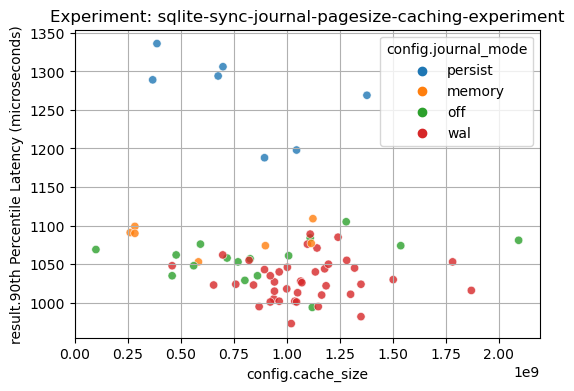

In [16]:
plt.rcParams["figure.figsize"] = (6, 4)

sns.scatterplot(data=df_lim, x="config.cache_size", y=SCORE, hue="config.journal_mode", marker='o', alpha=0.8)

plt.title("Experiment: " + exp.exp_id)
plt.grid()
plt.show()

Again, we see that setting `journal_mode` to `wal` and `cache_size` to the value between 500MB and 2GB seem to produce good results, but we need more experiments to explore that hypothesis.